## <center>Exercises 9: The Travelling Salesman Problem</center>

The Travelling Salesman Problem is a problem of optimization where we want to find the shortest path that connects a certain number (say $N$) of cities. The salesman starts from his hometown and wants to come back to it; he can visit each city only once and has to visit all of them: we are looking for the path that minimizes the length of his trip.

We are going to solve this problem via a genetic algorithm: if we think of every different path as an individual, we can build a population of paths and, via mutations and crossovers, we can create new generations; as the generations go on, if we choose properly the individuals that are involved in the creation of a generation from the previous one, the algorithm should result in a kind of natural selection that lets us reach the best path (the one with the minimum length).

The cost function that here we have to minimize is the length of the paths, namely
$$L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|$$
if $\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N$ are the coordinates of the $N$ cities in the cartesian plane.

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Exercise 1

In this exercise I will explain the code that I have written to solve the Travelling Salesman Problem exploiting the genetic algorithm. Unfortunately, my code compiles but gives me an error "Aborted (core dumped)" while executing that I was not able to solve.

#### Organization of the classes:
To solve this problem, I created three different classes:
- class *city*: it represents the city and its private members are an index (which is like the name of the city), a coordinate $x$ and a coordinate $y$ of the city in the cartesian plane
- class *path*: it represents the possible path the salesman may follow and it contains as private members the number of cities in it, a vector of cities and a vector of the indexes of those cities; the elements of these vectors are ordered from the first city visited to the last one
- class *population*: it represents the population of paths (one generation) and its private members are the number of paths in every population, the number of cities in every path and a vector of paths, that are all the possible paths the salesman can follow according to that particular generation

Each path has to start from the hometown (city $1$), so as to reduce the final best path to one (every path can be read clockwise or anticlockwise, if we always set the first city to $1$ we can avoid this ambiguity). Moreover, every path needs to have all the cities once: that's why I introduced a *check* operator, that checks that each path of a population satisfies these restraints.

In this exercise the cities are built randomly on a circumference of radius $1$ or inside a square of side $1$. We are working with $34$ cities.
<br> The figures below show the cities I have built on the circumference and inside the square.

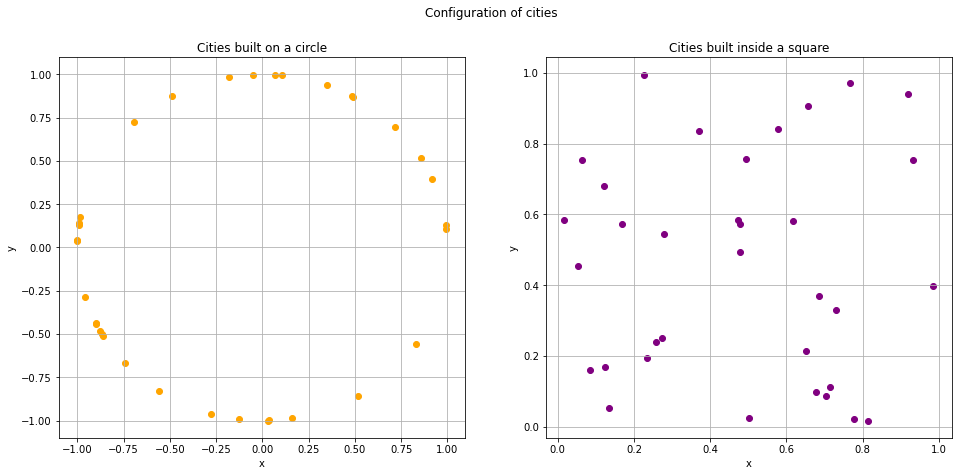

In [8]:
# loading data
index_circle, x_circle, y_circle = np.loadtxt("./ex_1/Output/cities_conf_circle.out", usecols=(0,1,2), delimiter=None, unpack='true')
index_square, x_square, y_square = np.loadtxt("./ex_1/Output/cities_conf_square.out", usecols=(0,1,2), delimiter=None, unpack='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Configuration of cities')

ax1.scatter(x_circle,y_circle,color='orange')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Cities built on a circle')
ax1.grid(True)

ax2.scatter(x_square,y_square,color='purple')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Cities built inside a square')
ax2.grid(True)

plt.show()

#### Mutation and crossover operators:
In order to exploit the genetic algorithm, I introduced some mutation operators to create the new generation from the previous one. Each mutation operator has a probability $p_{mutation}$ of occurring: for each individual of the newly generated population I called the mutation operators according to the probability of each particular mutation.
<br> The mutations I introduced are the following:
- swapping two cities in a path, for example $[1,2,3,4,5]$ becomes $[1,2,5,4,3]$
- permuting two groups of $m$ cities, for example $[1,2,3,4,5]$ becomes $[1,4,5,2,3]$ if we permute the groups $2,3$ and $4,5$
- shifting $m$ contiguous cities between two particular indexes $i^*$ and $i^*+m$ of $+n$ positions, for example $[1,2,3,4,5]$ becomes $[1,3,4,2,5]$ if we shift the cities between index $1$ and index $3$ of $2$ positions
- inverting the order of $m$ contiguous cities between indexes $i^*$ and $i^*+m$, for example $[1,2,3,4,5]$ becomes $[1,2,5,4,3]$ if we invert the order of the last three cities

All these mutations have to preserve the presence of city $1$ in the first position of every path. To choose which paths to use for creating the next generation I decided to select some paths in the ordered population (from the path with minimum length to the path with maximum length) according to 
$$ i= int(M r^p) +1 $$
with $M$ being the number of paths in a population and an adequate value of $p$ that takes more paths in the first positions (they are the shortest); a good value of $p$ could be between $0.5$ and $1$, the bigger it is and the more it selects the first paths, but in order to maintain a certain diversity we could choose to make it not too big.

The algorithm should be able to work well with this mutations, but a crossover operator can be added too: selecting a mother-path and a father-path as explained before, we find a random index and cut those paths right after that; we will generate two sons that have the same part before the index as the parents, after the index the cities that don't appear in each son will be added according to the order in which they appear in the other parent. For example, $[1,2,3,4,5]$ and $[1,5,4,3,2]$ generate $[1,2,3,|5,4]$ and $[1,5,4,|3,2]$ if we cut after position $2$.

#### The genetic algorithm:
My genetic algorithm, after reading some input information from a file (number of cities and paths in each population, number of generations, how to build cities, the probabilities of the various genetic operators, the exponent $p$ of the selection operator), starts by building the cities on a circumference or on a square while writing their index and their coordinates on a file. Then it creates the generation zero: it first initializes all paths with the cities wrote in the file in the same order, then it makes a random number of swaps between random positions in each path; I also added a random number of shifts in the whole group of cities except for the first one; both these mutations are called according to their probability.
<br> This ancestor population is now sorted from the shortest path to the longest, printing the average length of the best half of the population and the minimum length in a file (we want to see how they change as a function of the number of generations).

<br> The next generation can now be created: I decided to select the individuals with the selection operator from the previous generation and put them all in this new generation; with a routine of mutations and crossovers I introduce diversity in these paths, that, since they have been selected from the first positions of the old generation, are still too similar to each other. At this point I update the previous generation with the current one, preparing for the next one, and I sort this new ancestor in order to print its average length of the best half and its minimum length.

<br> Repeating this procedure until we have created all the generations we want, we should be able to find the best path in the first position of the vector of paths of the last generation.

#### My problems:
The error that doesn't let me execute the program occurs when I try to initialize the generation right after generation zero. It could have something to do with the constructors of the classes; nevertheless I tried with different types of constructors (both empty and passing input) but the error stayed the same. 
<br> Moreover, the crossover operator doesn't work: in my opinion the implementation is right, but it doesn't register the modifications in the son paths.

#### What I have done:
In the folder "ex_1" we can find three other folders:
- "idea_GA" contains my idea of the genetic algorithm, namely how I would have implemented the algorithm if it weren't for the error in the execution
- "methods_check" contains a main with my checks of the various methods of the classes I have created; they all work well except for the crossover operator
- "Output" contains the cities built on a circumference and the cities built inside a square